In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from siphon.catalog import TDSCatalog
from siphon.radarserver import RadarServer
from siphon.cdmr import Dataset
from metpy.plots import ctables, add_timestamp, add_metpy_logo, USCOUNTIES, USSTATES
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import numpy as np

%matplotlib inline

In [2]:
cat = TDSCatalog('https://thredds.ucar.edu/thredds/radarServer/catalog.xml')

In [3]:
rs = RadarServer(cat.catalog_refs['NEXRAD Level III Radar from IDD'].href)

In [4]:
query = rs.query()
now = datetime.utcnow()
query.stations('JAX').time_range(now - timedelta(hours=1), now).variables('N0Q')

var=N0Q&time_start=2019-09-04T23%3A01%3A06.361074&time_end=2019-09-05T00%3A01%3A06.361074&stn=JAX

In [5]:
query_cat = rs.get_catalog(query)

In [6]:
def plot_radar(data, field_name):
    rng = data.variables['gate'][:]
    az = data.variables['azimuth'][:]
    ref = data.variables[field_name][:]
    
    distance_in_degrees_lon = 3.0
    distance_in_degrees_lat = 1.5
    ax.set_extent([data.RadarLongitude - distance_in_degrees_lon,
                   data.RadarLongitude + distance_in_degrees_lon,
                   data.RadarLatitude - distance_in_degrees_lat,
                   data.RadarLatitude + distance_in_degrees_lat])
    
    x = rng * np.sin(np.deg2rad(az))[:, None]
    y = rng * np.cos(np.deg2rad(az))[:, None]
    
    norm, cmap = ctables.registry.get_with_range('NWSReflectivity', -30, 100)
    
    mesh = ax.pcolormesh(x, y, ref, cmap=cmap, norm=norm, zorder=1)
    
    return mesh
    

In [7]:
field_name = 'BaseReflectivityDR'

data = query_cat.datasets[0].remote_access()

proj = ccrs.LambertConformal(central_longitude=data.RadarLongitude,
                                    central_latitude=data.RadarLatitude)

C:\Users\rayha\Anaconda3\envs\metpy2\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
C:\Users\rayha\Anaconda3\envs\metpy2\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


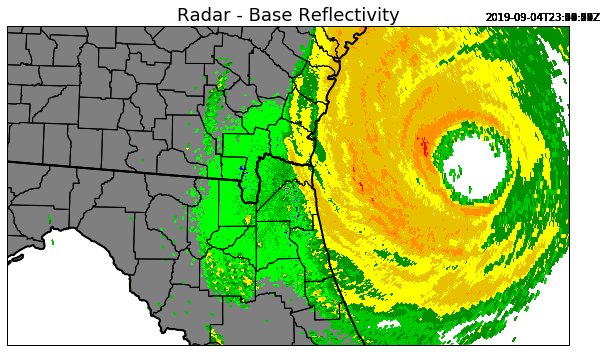

In [16]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
ax = fig.add_subplot(1, 1, 1, projection = proj)

artists = []

ax.set_title('Radar - Base Reflectivity', {'fontsize': 18})
ax.add_feature(USSTATES.with_scale('5m'), facecolor='tab:gray', zorder=0)
ax.add_feature(USSTATES.with_scale('5m'), edgecolor='black', linewidth=2, zorder=2)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=1, zorder=2)

for ds_name in sorted(query_cat.datasets):
    ds = query_cat.datasets[ds_name]
    data = Dataset(ds.access_urls['CdmRemote'])
    
    field_name = [var.name for var in data.variables.values()
                  if var.ndim >=2 and not var.name.endswith('RAW')][0]
    
    text = ax.text(0.85, 1.02, data.time_coverage_start, ha='left',
                   transform=ax.transAxes)
    
    mesh = plot_radar(data, field_name)
    
    artists.append([text, mesh])

In [17]:
plt.rcParams['animation.html'] = 'jshtml'

In [18]:
anim = ArtistAnimation(fig, artists, interval=100)
anim

In [19]:
anim.save('dorian.mp4', writer='ffmpeg')